# Chapter 6: Multiple Linear Regression - Solution


> (c) 2019-2020 Galit Shmueli, Peter C. Bruce, Peter Gedeck 
>
> _Data Mining for Business Analytics: Concepts, Techniques, and Applications in Python_ (First Edition) 
> Galit Shmueli, Peter C. Bruce, Peter Gedeck, and Nitin R. Patel. 2019.
>
> Date: 2020-03-08
>
> Python Version: 3.8.2
> Jupyter Notebook Version: 5.6.1
>
> Packages:
>   - dmba: 0.0.12
>   - matplotlib: 3.2.0
>   - numpy: 1.18.1
>   - pandas: 1.0.1
>   - seaborn: 0.10.0
>   - scikit-learn: 0.22.2
>   - statsmodels: 0.11.1
>
> The assistance from Mr. Kuber Deokar and Ms. Anuja Kulkarni in preparing these solutions is gratefully acknowledged.


In [1]:
# import required functionality for this chapter
from pathlib import Path

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import statsmodels.formula.api as sm

import matplotlib.pylab as plt
import seaborn as sns

from dmba import regressionSummary, exhaustive_search
from dmba import backward_elimination, forward_selection, stepwise_selection
from dmba import adjusted_r2_score, AIC_score #, BIC_score

%matplotlib inline

In [2]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
DATA = Path('.')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

# Problem 6.3 Predicting Airfare on New Routes.

The following problem takes place in the United States in the late 1990s, when many major US cities were facing issues with airport congestion, partly as a result of the 1978 deregulation of airlines. Both fares and routes were freed from regulation, and low-fare carriers such as Southwest (SW) began competing on existing routes and starting nonstop service on routes that previously lacked it. Building completely new airports is generally not feasible, but sometimes decommissioned military bases or smaller municipal airports can be reconfgured as regional or larger commercial airports. There are numerous players and interests involved in the issue (airlines, city, state and federal authorities, civic groups, the military, airport operators), and an aviation consulting firm is seeking advisory contracts with these players. The frm needs predictive models to support its consulting service. One thing the frm might want to be able to predict is fares, in the event a new airport is brought into service. The frm starts with the fle Airfares.csv, which contains real data that were collected between Q3-1996 and Q2-1997. The variables in these data are listed in Table 6.13, and are believed to be important in predicting FARE. Some airport-to-airport data are available, but most data are at the city-to-city level. One question that will be of interest in the analysis is the eﬀect that the presence or absence of Southwest has on FARE.

![TABLE6.13](img\TABLE_6.13.PNG)


In [3]:
# load the data and review
airfares_df = pd.read_csv(DATA / 'Airfares.csv')
# check data dimension
print('\ndimension\n',airfares_df.shape)
# view few records
print('\nfirst five record\n')
print(airfares_df.head())
# variable types
print('\nData Type')
airfares_df.dtypes


dimension
 (638, 18)

first five record

  S_CODE                  S_CITY E_CODE                  E_CITY  COUPON  NEW  \
0      *  Dallas/Fort Worth   TX      *  Amarillo            TX    1.00    3   
1      *  Atlanta             GA      *  Baltimore/Wash Intl MD    1.06    3   
2      *  Boston              MA      *  Baltimore/Wash Intl MD    1.06    3   
3    ORD  Chicago             IL      *  Baltimore/Wash Intl MD    1.06    3   
4    MDW  Chicago             IL      *  Baltimore/Wash Intl MD    1.06    3   

  VACATION   SW       HI  S_INCOME  E_INCOME    S_POP    E_POP        SLOT  \
0       No  Yes  5291.99   28637.0   21112.0  3036732   205711        Free   
1       No   No  5419.16   26993.0   29838.0  3532657  7145897        Free   
2       No   No  9185.28   30124.0   29838.0  5787293  7145897        Free   
3       No  Yes  2657.35   29260.0   29838.0  7830332  7145897  Controlled   
4       No  Yes  2657.35   29260.0   29838.0  7830332  7145897        Free   

   GATE 

S_CODE       object
S_CITY       object
E_CODE       object
E_CITY       object
COUPON      float64
NEW           int64
VACATION     object
SW           object
HI          float64
S_INCOME    float64
E_INCOME    float64
S_POP         int64
E_POP         int64
SLOT         object
GATE         object
DISTANCE      int64
PAX           int64
FARE        float64
dtype: object

In [4]:
# preprocess
# remove first four variables 'S_CODE', 'S_CITY', 'E_CODE', 'E_CITY'
selected_var = ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE',
                'DISTANCE', 'PAX', 'FARE']
airfares_df = airfares_df[selected_var]
airfares_df.dtypes

COUPON      float64
NEW           int64
VACATION     object
SW           object
HI          float64
S_INCOME    float64
E_INCOME    float64
S_POP         int64
E_POP         int64
SLOT         object
GATE         object
DISTANCE      int64
PAX           int64
FARE        float64
dtype: object

__6.3.a.__ Explore the numerical predictors and response (FARE) by creating a correlation table and examining some scatterplots between FARE and those predictors. What seems to be the best single predictor of FARE?

__Answer:__

In [40]:
# create a new dataframe with numerical predictors
predictors_df = airfares_df

columns = list(airfares_df.columns)
columns.remove('VACATION')
columns.remove('SW')
columns.remove('SLOT')
columns.remove('GATE')
predictors_df = predictors_df[columns]
predictors_df.columns

Index(['COUPON', 'NEW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP',
       'DISTANCE', 'PAX', 'FARE'],
      dtype='object')

In [41]:
#correlation table
predictors_df.corr()
#corr.style.background_gradient()

,COUPON,NEW,HI,S_INCOME,E_INCOME,S_POP,E_POP,DISTANCE,PAX,FARE
COUPON,1.000000,0.020223,-0.347252,-0.088403,0.046889,-0.107763,0.094970,0.746805,-0.336974,0.496537
NEW,0.020223,1.000000,0.054147,0.026597,0.113377,-0.016672,0.058568,0.080965,0.010495,0.091730
HI,-0.347252,0.054147,1.000000,-0.027382,0.082393,-0.172495,-0.062456,-0.312375,-0.168961,0.025195
S_INCOME,-0.088403,0.026597,-0.027382,1.000000,-0.138864,0.517187,-0.272280,0.028153,0.138197,0.209135
E_INCOME,0.046889,0.113377,0.082393,-0.138864,1.000000,-0.144059,0.458418,0.176531,0.259961,0.326092
S_POP,-0.107763,-0.016672,-0.172495,0.517187,-0.144059,1.000000,-0.280143,0.018437,0.284611,0.145097
E_POP,0.094970,0.058568,-0.062456,-0.272280,0.458418,-0.280143,1.000000,0.115640,0.314698,0.285043
DISTANCE,0.746805,0.080965,-0.312375,0.028153,0.176531,0.018437,0.115640,1.000000,-0.102482,0.670016
PAX,-0.336974,0.010495,-0.168961,0.138197,0.259961,0.284611,0.314698,-0.102482,1.000000,-0.090705
FARE,0.496537,0.091730,0.025195,0.209135,0.326092,0.145097,0.285043,0.670016,-0.090705,1.000000


DISTANCE is the best single predictor of FARE with correlation coefficient of 0.67.

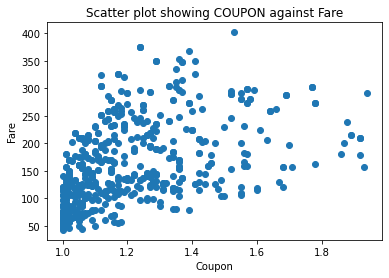

In [42]:
# Plot of coupon against fare
plt.scatter(airfares_df.COUPON, airfares_df.FARE)
plt.title('Scatter plot showing COUPON against Fare')
plt.xlabel('Coupon')
plt.ylabel('Fare')
plt.show()

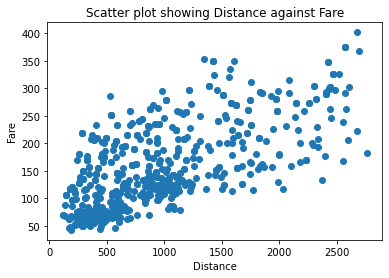

In [43]:
# Plot of distance against fare
plt.scatter(airfares_df.DISTANCE, airfares_df.FARE)
plt.title('Scatter plot showing Distance against Fare')
plt.xlabel('Distance')
plt.ylabel('Fare')
plt.show()

__6.3.b.__ Explore the categorical predictors (excluding the first four) by computing the percentage of ﬂights in each category. Create a pivot table with the average fare in each category. Which categorical predictor seems best for predicting FARE?

__Answer:__ 

In [44]:
pivot1 = pd.pivot_table(airfares_df, index= 'VACATION', values= "FARE",
               aggfunc= [np.mean])
print(pivot1)

                mean
                FARE
VACATION            
No        173.552500
Yes       125.980882


In [45]:
pd.pivot_table(airfares_df, index= 'SW', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
SW,
No,188.182793
Yes,98.382268


In [46]:
pd.pivot_table(airfares_df, index= 'SLOT', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
SLOT,
Controlled,186.059396
Free,150.825680


In [47]:
pd.pivot_table(airfares_df, index= 'GATE', values= "FARE",
               aggfunc= [np.mean])

,mean
,FARE
GATE,
Constrained,193.129032
Free,153.095953


SW is the single best categorical predictor of FARE.

__6.3.c.__ Find a model for predicting the average fare on a new route:

__6.3.c.i.__ Convert categorical variables (e.g., SW) into dummy variables. Then, partition the data into training and validation sets. The model will be fit to the training data and evaluated on the validation set.

__Answer:__ 

The columns VACATION, SW, SLOT, and GATE are not numeric. Convert them to numeric.

In [48]:
airfares_df['VACATION'] = [1 if v == 'Yes' else 0 for v in airfares_df['VACATION']]
airfares_df['SW'] = [1 if v == 'Yes' else 0 for v in airfares_df['SW']]
airfares_df['SLOT'] = [1 if v == 'Controlled' else 0 for v in airfares_df['SLOT']]
airfares_df['GATE'] = [1 if v == 'Constrained' else 0 for v in airfares_df['GATE']]

In [49]:
#partition the data into training (60%) and validation (40%) sets
predictors = ['COUPON', 'NEW', 'VACATION', 'SW', 'HI', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE',
              'PAX']
outcome = 'FARE'

# partition the data
X = pd.get_dummies(airfares_df[predictors], drop_first=True)
y = airfares_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (382, 13) Validation set: (256, 13)


__6.3.c.ii.__ Use stepwise regression to reduce the number of predictors. You can ignore the frst four predictors (S_CODE, S_CITY, E_CODE, E_CITY). Report the estimated model selected.

__Answer:__ 

In [50]:
# stepwise regression
def train_model(variables):
    if len(variables) == 0:
        return None
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    if len(variables) == 0:
        return AIC_score(train_y, [train_y.mean()] * len(train_y), model, df=1)
    return AIC_score(train_y, model.predict(train_X[variables]), model)

best_model, best_variables = stepwise_selection(train_X.columns, train_model, score_model, verbose=True)
print("Best Subset:", best_variables)

Variables: COUPON, NEW, VACATION, SW, HI, S_INCOME, E_INCOME, S_POP, E_POP, SLOT, GATE, DISTANCE, PAX
Start: score=4379.42, constant
Step: score=4149.88, add DISTANCE
Step: score=4025.89, add SW
Step: score=3913.59, add VACATION
Step: score=3890.27, add HI
Step: score=3873.33, add GATE
Step: score=3852.81, add SLOT
Step: score=3850.30, add PAX
Step: score=3844.58, add E_POP
Step: score=3826.43, add S_POP
Step: score=3821.88, add E_INCOME
Step: score=3821.88, unchanged None
Best Subset: ['DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']


According to the output the model with 10 predictors (11 coefficients) is the best one.

__6.3.c.iii.__ Repeat (ii) using exhaustive search instead of stepwise regression. Compare the resulting best model to the one you obtained in (ii) in terms of the predictors that are in the model.

__Answer:__ 

In [51]:
# exhaustive search
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

     n     r2adj          AIC  COUPON  DISTANCE  E_INCOME  E_POP   GATE     HI    NEW    PAX  \
0    1  0.453107  4149.881509   False      True     False  False  False  False  False  False   
1    2  0.605715  4025.892420   False      True     False  False  False  False  False  False   
2    3  0.706909  3913.585125   False      True     False  False  False  False  False  False   
3    4  0.724977  3890.268211   False      True     False  False  False   True  False  False   
4    5  0.737584  3873.328296   False      True     False  False   True   True  False  False   
5    6  0.751947  3852.808698   False      True     False  False   True   True  False  False   
6    7  0.758747  3843.170960   False      True     False   True  False   True  False   True   
7    8  0.765105  3833.945866   False      True     False   True   True   True  False   True   
8    9  0.770266  3826.433471   False      True     False   True   True   True  False   True   
9   10  0.773567  3821.876901   False   

Stepwise selection produced best model with these 10 variables (11 coefficients): 'DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME'. It excluded variables named COUPON, NEW and S_INCOME.

Exhaustive search also produced a model with 10 predictors (11 coefficients) which is the best one (according to adjusted R-squared and AIC values). It excluded the same variables named COUPON, NEW and S_INCOME.

__6.3.c.iv.__ Compare the predictive accuracy of both models (ii) and (iii) using measures such as RMSE and average error and lift charts.

__Answer:__

Since models are same they will have the same predictive accuracy.

In [52]:
# predictors and outcome
predictors = ['DISTANCE', 'SW', 'VACATION', 'HI', 'GATE', 'SLOT', 'PAX', 'E_POP', 'S_POP', 'E_INCOME']
outcome = 'FARE'
X = train_X[predictors]
y = train_y

# fit the regression model y on x
airfares_lm = LinearRegression()
airfares_lm.fit(X,y)

# print coefficients
print('intercept ', airfares_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': airfares_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, airfares_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
airfares_lm_pred = airfares_lm.predict(valid_X[predictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, airfares_lm_pred)


intercept  17.56489387958925
  Predictor  coefficient
0  DISTANCE     0.075558
1        SW   -43.031272
2  VACATION   -35.865596
3        HI     0.007188
4      GATE    21.410803
5      SLOT    13.915304
6       PAX    -0.000829
7     E_POP     0.000004
8     S_POP     0.000004
9  E_INCOME     0.001148

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 34.8867
            Mean Absolute Error (MAE) : 27.1374
          Mean Percentage Error (MPE) : -4.5313
Mean Absolute Percentage Error (MAPE) : 20.1672

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : -1.8591
       Root Mean Squared Error (RMSE) : 36.1129
            Mean Absolute Error (MAE) : 28.5252
          Mean Percentage Error (MPE) : -6.7084
Mean Absolute Percentage Error (MAPE) : 21.7198


__6.3.c.v.__ Using model (iii), predict the average fare on a route with the following characteristics: COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28,760, E_INCOME = 27,664, S_POP = 4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12,782, DISTANCE = 1976 miles.

__Answer:__ 

In [53]:
# Fare when SW does not cover this route
# enter new data in data frame format
new_data = pd.DataFrame([
    {'VACATION': 0, 'SW': 0, 'HI': 4442.141, 'E_INCOME': 27664, 'S_POP': 4557004, 'E_POP': 3195503, 'SLOT': 1, 'GATE': 1,
     'PAX': 12782, 'DISTANCE': 1976}])
    
print(new_data)

   VACATION  SW        HI  E_INCOME    S_POP    E_POP  SLOT  GATE    PAX  \
0         0   0  4442.141     27664  4557004  3195503     1     1  12782   

   DISTANCE  
0      1976  


In [54]:
# predict Fare when SW does not cover this route
pred = airfares_lm.predict(new_data[predictors])
print(pred)

[287.04763737]


__6.3.c.vi.__ Predict the reduction in average fare on the route in (v) if Southwest decides to cover this route [using model (iii)].

__Answer:__ 

In [55]:
# predict Fare when SW decides to cover this route
new_data = pd.DataFrame([
    {'VACATION': 0, 'SW': 1, 'HI': 4442.141, 'S_INCOME': 28760, 'E_INCOME': 27664, 'S_POP': 4557004, 'E_POP': 3195503, 'SLOT': 1, 'GATE': 1,
     'PAX': 12782, 'DISTANCE': 1976}])
pred1 = airfares_lm.predict(new_data[predictors])
print(pred1)

[244.01636531]


In [56]:
# reduction in average fare after southwest decided to cover this route
reduction = pred - pred1
print(reduction)

[43.03127206]


So the reduction in average fare after southwest decided to cover this route is $43.

__6.3.c.vii.__ In reality, which of the factors will not be available for predicting the average fare from a new airport (i.e., before ﬂights start operating on those routes)? Which ones can be estimated? How?

__Answer:__

Several of the variables would not be available until after flights start operating on the route.
         
 COUPON    - Not Available   
 NEW       - Not Available   
 VACATION  - Available      
 SW        - Not Available  
 HI        - Not Available   
 S_INCOME  - Available    
 E_INCOME  - Available    
 S_POP     - Available    
 E_POP     - Available    
 SLOT      - Available    
 GATE      - Available    
 DISTANCE  - Available    
 PAX       - Not Available  

__6.3.c.viii.__ Select a model that includes only factors that are available before ﬂights begin to operate on the new route. Use an exhaustive search to fnd such a model.

__Answer:__

In [57]:
# partition the data into training (60%) and validation (40%) sets
predictors = ['VACATION', 'S_INCOME', 'E_INCOME', 'S_POP', 'E_POP', 'SLOT', 'GATE', 'DISTANCE']
outcome = 'FARE'

# partition the data
X = pd.get_dummies(airfares_df[predictors], drop_first=True)
y = airfares_df[outcome]
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

print('Training set:', train_X.shape, 'Validation set:', valid_X.shape)

Training set: (382, 8) Validation set: (256, 8)


In [58]:
# exhaustive search
def train_model(variables):
    model = LinearRegression()
    model.fit(train_X[variables], train_y)
    return model

def score_model(model, variables):
    pred_y = model.predict(train_X[variables])
    # we negate as score is optimized to be as low as possible
    return -adjusted_r2_score(train_y, pred_y, model)

allVariables = train_X.columns
results = exhaustive_search(allVariables, train_model, score_model)

data = []
for result in results:
    model = result['model']
    variables = result['variables']
    AIC = AIC_score(train_y, model.predict(train_X[variables]), model)
    
    d = {'n': result['n'], 'r2adj': -result['score'], 'AIC': AIC}
    d.update({var: var in result['variables'] for var in allVariables})
    data.append(d)
pd.set_option('display.width', 100)
print(pd.DataFrame(data, columns=('n', 'r2adj', 'AIC') + tuple(sorted(allVariables))))
pd.reset_option('display.width')

   n     r2adj          AIC  DISTANCE  E_INCOME  E_POP   GATE   SLOT  S_INCOME  S_POP  VACATION
0  1  0.453107  4149.881509      True     False  False  False  False     False  False     False
1  2  0.562472  4065.645719      True     False  False  False  False     False  False      True
2  3  0.607897  4024.763754      True     False  False   True  False     False  False      True
3  4  0.639707  3993.431429      True     False  False   True   True     False  False      True
4  5  0.655706  3977.066487      True      True  False   True   True     False  False      True
5  6  0.660329  3972.885153      True      True  False   True   True      True  False      True
6  7  0.664409  3969.248469      True      True   True   True   True      True  False      True
7  8  0.663807  3970.910599      True      True   True   True   True      True   True      True


Model with 7 predictors (8 coefficients) is the best one among other models in this case. That excludes the predictor S_POP.

__6.3.c.ix.__ Use the model in (viii) to predict the average fare on a route with characteristics COUPON = 1.202, NEW = 3, VACATION = No, SW = No, HI = 4442.141, S_INCOME = 28,760, E_INCOME = 27,664, S_ POP = 4,557,004, E_POP = 3,195,503, SLOT = Free, GATE = Free, PAX = 12782, DISTANCE = 1976 miles.

__Answer:__ 

In [59]:
# predictors and outcome
predictors = ['DISTANCE', 'VACATION', 'GATE', 'SLOT', 'E_POP', 'E_INCOME', 'S_INCOME']
outcome = 'FARE'
X = train_X[predictors]
y = train_y

#fit the regression model y on x
airfares_lm = LinearRegression()
airfares_lm.fit(X,y)

# print coefficients
print('intercept ', airfares_lm.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'coefficient': airfares_lm.coef_}))

# print performance measures (training set)
print("\nModel performance on training data:")
regressionSummary(train_y, airfares_lm.predict(train_X[predictors]))

# predict prices in validation set, print first few predicted/actual values and residuals
airfares_lm_pred = airfares_lm.predict(valid_X[predictors])

# print performance measures (validation set)
print("\nModel performance on validation data:")
regressionSummary(valid_y, airfares_lm_pred)


intercept  -40.8073738366258
  Predictor  coefficient
0  DISTANCE     0.077434
1  VACATION   -41.230763
2      GATE    38.056133
3      SLOT    18.903701
4     E_POP     0.000002
5  E_INCOME     0.001974
6  S_INCOME     0.002240

Model performance on training data:

Regression statistics

                      Mean Error (ME) : -0.0000
       Root Mean Squared Error (RMSE) : 42.6426
            Mean Absolute Error (MAE) : 33.6897
          Mean Percentage Error (MPE) : -8.2491
Mean Absolute Percentage Error (MAPE) : 25.3452

Model performance on validation data:

Regression statistics

                      Mean Error (ME) : 0.3728
       Root Mean Squared Error (RMSE) : 43.8816
            Mean Absolute Error (MAE) : 35.2079
          Mean Percentage Error (MPE) : -9.9589
Mean Absolute Percentage Error (MAPE) : 26.4530


In [60]:
# predict Fare for new data
print(airfares_lm.predict(new_data[predictors]))

[295.58795228]


So the average fare on this route is $295.59. 

__6.3.c.x.__ Compare the predictive accuracy of this model with model (iii). Is this model good enough, or is it worthwhile reevaluating the model once ﬂights begin on the new route?

__Answer:__ 

RMS error is higher in model (viii). We need to reevaluate the model once flights commence on the new routes.

__6.3.d.__ In competitive industries, a new entrant with a novel business plan can have a disruptive eﬀect on existing firms. If a new entrant’s business model is sustainable, other players are forced to respond by changing their business practices. If the goal of the analysis was to evaluate the eﬀect of Southwest Airlines’ presence on the airline industry rather than predicting fares on new routes, how would the analysis be diﬀerent? Describe technical and conceptual aspects.